Code inspired by http://pyro.ai/examples/dkl.html?highlight=mnist

In [1]:
import time
from typing import Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

import pyro
import pyro.contrib.gp as gp
import pyro.infer as infer
from pyro.contrib.examples.util import get_data_loader
from pathlib import Path
import os


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train(device, log_interval, train_loader, gpmodule, optimizer, loss_fn, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        gpmodule.set_data(data, target)
        optimizer.zero_grad()
        loss = loss_fn(gpmodule.model, gpmodule.guide)
        loss.backward()
        optimizer.step()
        batch_idx = batch_idx + 1
        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch:2d} [{batch_idx * len(data):5d}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):2.0f}%)]\tLoss: {loss:.6f}")


def test(device, test_loader, gpmodule):
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # get prediction of GP model on new data
        f_loc, f_var = gpmodule(data)
        # use its likelihood to give prediction class
        pred = gpmodule.likelihood(f_loc, f_var)
        # compare prediction and target to count accuracy
        correct += pred.eq(target).long().cpu().sum().item()

    print(f"\nTest set: Accuracy: {correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset):.2f}%)\n")


def get_model(Xu):
    cnn = CNN()
    # Create deep kernel by warping RBF with CNN.
    # CNN will transform a high dimension image into a low dimension 2D tensors for RBF kernel.
    # This kernel accepts inputs are inputs of CNN and gives outputs are covariance matrix of RBF
    # on outputs of CNN.
    rbf = gp.kernels.RBF(input_dim=10, lengthscale=torch.ones(10))
    deep_kernel = gp.kernels.Warping(rbf, iwarping_fn=cnn)

    likelihood = gp.likelihoods.MultiClass(num_classes=10)
    # Because we use Categorical distribution in MultiClass likelihood, we need GP model
    # returns a list of probabilities of each class. Hence it is required to use
    # latent_shape = 10.
    latent_shape = torch.Size([10])

    # Turns on "whiten" flag will help optimization for variational models.
    gpmodule = gp.models.VariationalSparseGP(
        X=Xu,
        y=None,
        kernel=deep_kernel,
        Xu=Xu,
        likelihood=likelihood,
        latent_shape=latent_shape,
        num_data=60000,
        whiten=True,
        jitter=2e-6,
    )
    return gpmodule


def prep_loaders(data_dir: Path, batch_size=64, test_batch_size=1000):
    train_loader = get_data_loader(
        dataset_name="MNIST",
        data_dir=data_dir,
        batch_size=batch_size,
        dataset_transforms=[transforms.Normalize((0.1307,), (0.3081,))],
        is_training_set=True,
        shuffle=True,
    )
    test_loader = get_data_loader(
        dataset_name="MNIST",
        data_dir=data_dir,
        batch_size=test_batch_size,
        dataset_transforms=[transforms.Normalize((0.1307,), (0.3081,))],
        is_training_set=False,
        shuffle=False,
    )
    return train_loader, test_loader


def collect_inducing_points(train_dl: DataLoader, batch_size,
                            num_inducing=70,  # number of inducing input (default: 70)
                            ):
    # init inducing points (taken randomly from dataset)
    batches = []
    for i, (data, _) in enumerate(train_dl):
        batches.append(data)
        if i >= ((num_inducing - 1) // batch_size):
            break
    return torch.cat(batches)[: num_inducing].clone()


def train_model(gpmodule: nn.Module, train_dl: DataLoader, test_dl: DataLoader, lr=0.01, epochs=10, log_interval=10,
                jit=False,  # enables PyTorch jit
                seed=1):
    pyro.set_rng_seed(seed)
    torch.backends.cudnn.deterministic = True

    # train_loader.num_workers = 1
    # test_loader.num_workers = 1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gpmodule.to(device)

    optimizer = torch.optim.Adam(gpmodule.parameters(), lr=lr)

    elbo = infer.JitTraceMeanField_ELBO() if jit else infer.TraceMeanField_ELBO()
    loss_fn = elbo.differentiable_loss

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        train(device, log_interval, train_dl, gpmodule, optimizer, loss_fn, epoch)
        with torch.no_grad():
            test(device, test_dl, gpmodule)
        print(f"Amount of time spent for epoch {epoch}: {int(time.time() - start_time)}s\n")
    return gpmodule


/opt/miniconda3/envs/tf9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MNIST_DIR = Path(os.getcwd()) / 'minst-data'
batch_size = 64
train_dl, test_dl = prep_loaders(data_dir=MNIST_DIR, batch_size=batch_size)
Xu = collect_inducing_points(train_dl=train_dl, batch_size=batch_size, num_inducing=70)
gpmodule = get_model(Xu)

model = train_model(gpmodule=gpmodule, train_dl=train_dl, test_dl=test_dl)

downloading data
download complete.
downloading data
download complete.
Train Epoch:  1 [  640/60000 ( 1%)]	Loss: 136291.281250
Train Epoch:  1 [ 1280/60000 ( 2%)]	Loss: 133635.312500
Train Epoch:  1 [ 1920/60000 ( 3%)]	Loss: 108440.015625
Train Epoch:  1 [ 2560/60000 ( 4%)]	Loss: 98349.421875
Train Epoch:  1 [ 3200/60000 ( 5%)]	Loss: 85611.203125
Train Epoch:  1 [ 3840/60000 ( 6%)]	Loss: 64676.496094
Train Epoch:  1 [ 4480/60000 ( 7%)]	Loss: 45703.664062
Train Epoch:  1 [ 5120/60000 ( 9%)]	Loss: 47201.707031
Train Epoch:  1 [ 5760/60000 (10%)]	Loss: 33804.226562
Train Epoch:  1 [ 6400/60000 (11%)]	Loss: 26887.611328
Train Epoch:  1 [ 7040/60000 (12%)]	Loss: 19831.599609
Train Epoch:  1 [ 7680/60000 (13%)]	Loss: 23795.900391
Train Epoch:  1 [ 8320/60000 (14%)]	Loss: 16583.273438
Train Epoch:  1 [ 8960/60000 (15%)]	Loss: 13857.566406
Train Epoch:  1 [ 9600/60000 (16%)]	Loss: 8254.275391
Train Epoch:  1 [10240/60000 (17%)]	Loss: 13218.151367
Train Epoch:  1 [10880/60000 (18%)]	Loss: 1991

In [3]:
len(test_dl)

10

In [8]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.imshow(make_grid((images[:nmax]), nrow=8).permute(1, 2, 0))
    #ax.imshow(images[0][0].permute(1, 2, 0));
    
    def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


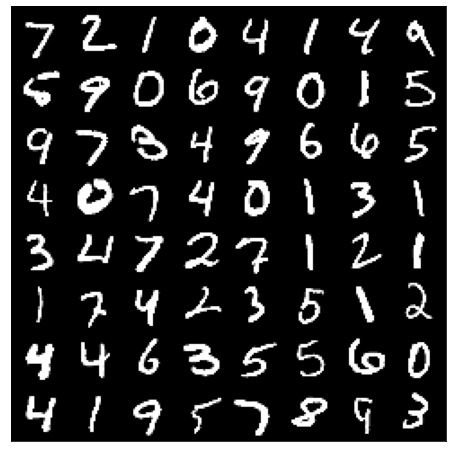

In [10]:
show_batch(test_loader)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        f_loc, f_var = model(data)
        pred = model.likelihood(f_loc, f_var)
        pr = pred.eq(target).long().cpu().sum().item()
        break

In [30]:
pred

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 3, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 9, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1,
        7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5,
        1, 4, 4, 7, 2, 3, 2, 1, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1,
        0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1,
        5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7,
        9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4,
        1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2,

In [31]:
f_loc.shape, f_var.shape, data.shape

(torch.Size([10, 1000]), torch.Size([10, 1000]), torch.Size([1000, 1, 28, 28]))

In [33]:
#pyro.get_param_store().save(MNIST_DIR/"mnist-params.mod")
#pyro.get_param_store().load(MNIST_DIR/"mnist-params.mod")

torch.save(model.state_dict(), MNIST_DIR/"mnist-state.save")
model.load_state_dict(torch.load( MNIST_DIR/"mnist-state.save"))

In [35]:
f_loc[0], f_var[0], target

(tensor([-3.9164, -2.3870, -2.5388,  9.3813, -1.8943, -2.4605, -1.3013, -3.1678,
         -1.8083, -3.7338, 10.2639, -1.8428, -3.9929,  9.9455, -2.2442, -3.0411,
         -3.2421, -3.5899, -1.1047, -2.4197, -3.6340, -2.2131, -2.0972, -2.0246,
         -2.4176,  9.8422, -3.4393, -1.8143,  8.4955, -2.4878, -2.9221, -2.3518,
         -3.1901, -1.5253, -4.0409, -4.5301, -4.3229, -2.1406, -0.9409, -1.8151,
         -2.2839, -4.1671, -2.1508, -4.6560, -3.4257, -2.3467, -2.6087, -3.1650,
         -1.5849, -2.0636, -1.9805, -2.7961, -1.8341, -2.0491, -2.4206, 10.5801,
         -2.2247, -2.6145, -3.4798, -2.1995, -3.9689, -1.1752, -2.4342, -3.4972,
         -4.0835, -2.0653, -0.2630, -1.2895, -3.0304, 10.8050, -3.6160,  9.4141,
         -3.4315, -3.7532, -2.2182, -3.6694, -2.5948, -2.3396, -3.0650, -4.0965,
         -3.3168, -2.3882, -3.9533, -3.8031, -1.2045, -2.2804, -4.3046, -3.7885,
         -2.2926, -2.7796, -2.7698, -2.0257, -4.3573, -3.1429, -1.7984, -0.1641,
         -2.1611, -4.5890, -